# Diode effect notebook 

*Parameter cells and Devices cells must be executed for any of the sections:
The sections of cells that must be executed are marked by  an astherisk as *

* The create device can be modified to merge any kind of device, in fact a modified function could make a fractal device wich starts from a minimum size and then merges with a copy of the device on a larger scale, this could prove an interesting study case
* Any od the functions used in this notebook can be used with any created device. It's just a matter of passing the device object to the function.
* To change the default simulation values you can edit the default_options and default_solutions functions to set the simulation times and any other parameters.
* Each simulation section should run independently of the other sections.


# Parameters*

In [1]:
from tdgl.visualization.animate import create_animation
from IPython.display import HTML, display
from IPython.display import clear_output
from tdgl.sources import ConstantField
from tdgl.geometry import box, circle
import matplotlib.pyplot as plt
import default_functions as df
import numpy as np
import tempfile
import h5py
import tdgl
import time
import os



C:\Users\alejo\anaconda3\envs\electro2\Lib\site-packages\cupy\_environment.py:596: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
C:\Users\alejo\anaconda3\envs\electro2\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawk

In [2]:
# ====================================================
# Default configuration
# ====================================================
os.environ["OPENBLAS_NUM_THREADS"] = "1"
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
length_units = "um"     
H5_DIR = "./project_field_h5_files"
os.makedirs(H5_DIR, exist_ok=True)
os.environ["OPENBLAS_NUM_THREADS"] = "1"
# Configuración de gráficas
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams['lines.linewidth'] = 2.0


In [3]:

# ====================================================
## 1. ⚙️ Global Parameters(Optimized)
# ====================================================

### 1.1. Material parameters
LENGTH_UNITS = "um"
xi = df.xi           
london_lambda = df.london_lambda  
d = df.d               
gamma = df.gamma            
###Main rectangle
# Ancho del puente (dimensión x)
width_x = 5.0
# Alto del puente (dimensión y)
height_y = 12.0
STRIPE_LENGTH = 0.01   # side of the square contact
OVERLAP = 0.5         # aditional space for overlapping
###Rectangulo pequeño
width_x2 = width_x/2
height_y2 =(height_y/2)+ 1
dimensions = {"width_x":width_x,"width_x2": width_x/2,"height_y":height_y,"height_y2":height_y2}
### 1.3. Parámetros de Malla
MAX_EDGE_LENGTH_IV = xi / 1.5
MAX_EDGE_LENGTH_VORTEX = xi / 1.5
SMOOTHING_STEPS = 100            
# Geometría inicial y capa
film_poly = tdgl.Polygon("film_base", points=box(width=width_x, height=height_y))
film_poly_down = tdgl.Polygon("film_pequeño", points=box(width=width_x2, height=height_y2)).translate(dx=-width_x/2)
half_geometry = film_poly.union(film_poly,film_poly_down)
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=gamma)
print(f'widths: width_x:{width_x},width_x2:{width_x2},height_y:{height_y},height_y2:{height_y2},height_y2_altered:{3}' )

widths: width_x:5.0,width_x2:2.5,height_y:12.0,height_y2:7.0,height_y2_altered:3


# Device*

Device and mesh creation

  Malla creada: 2944 puntos


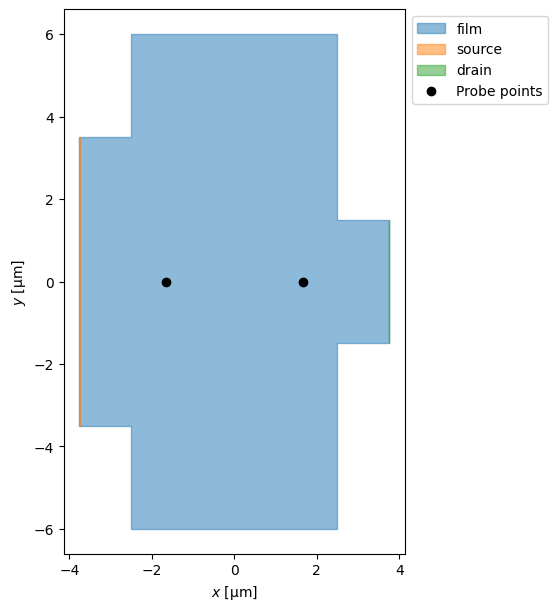

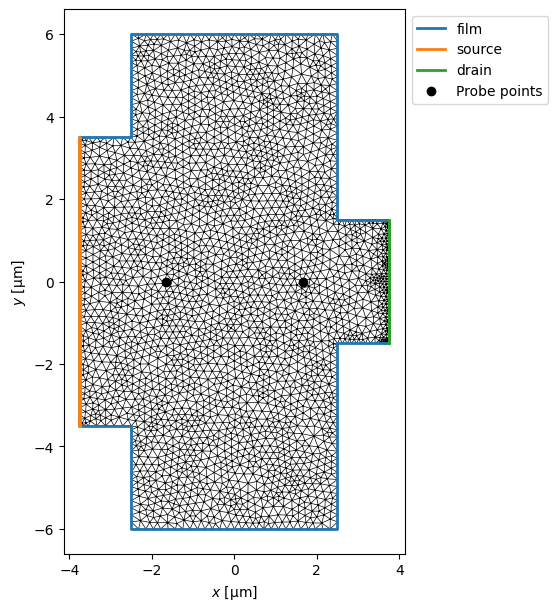

In [4]:
displacement = (width_x + width_x2 + STRIPE_LENGTH) / 2
device_fast = df.create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,incrementy=0,translationx=displacement)
fig, ax = device_fast.plot(mesh=True)

# Simulations

## 1) different fields for a fixed current

Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [01:04<00:00,  3.10tau/s ]


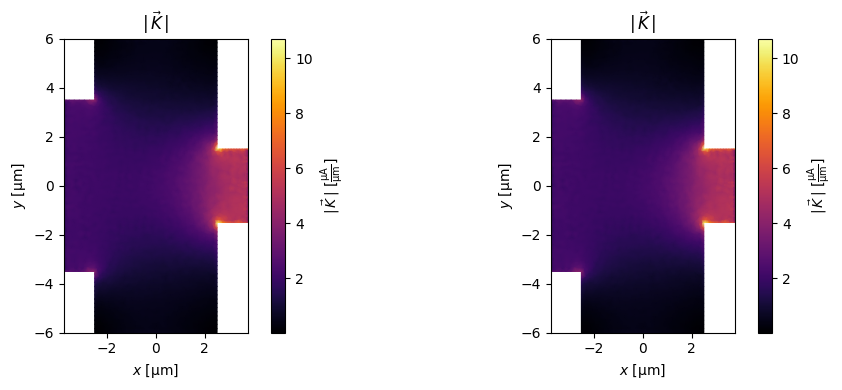

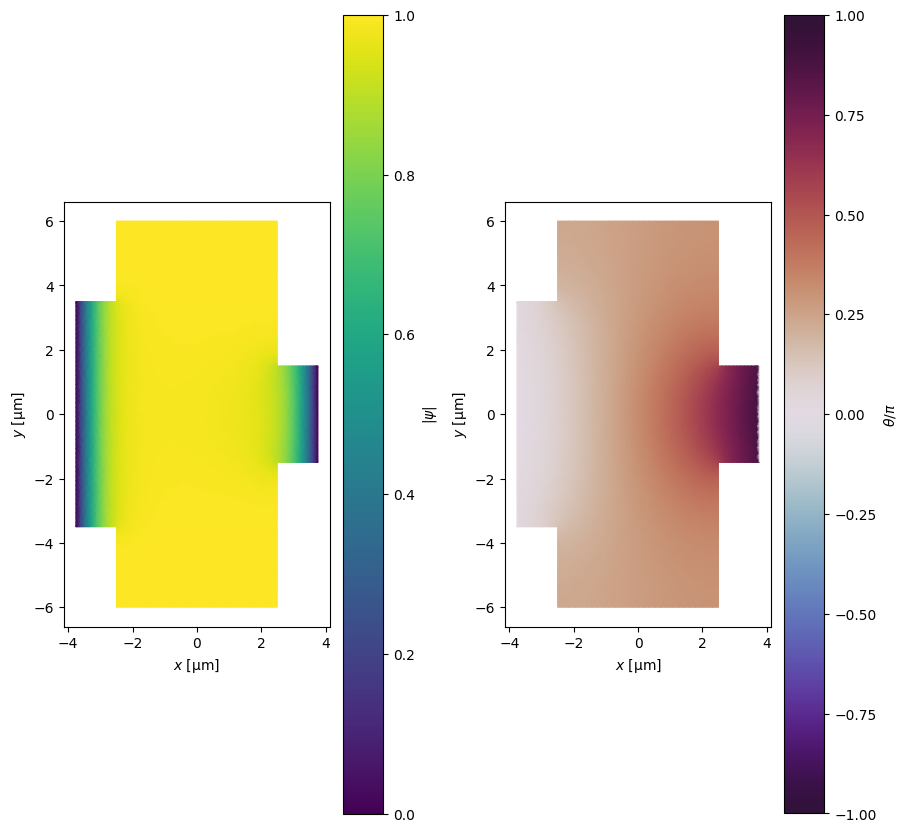

In [5]:
zero_field_solution = df.default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[15,-15],vector_potential = 0.0)
df.plot_solution(zero_field_solution)

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\zero_field_zero_current-1.h5.
Simulating: 100%|██████████████████████████████████████████████████████████████████| 200/200 [02:56<00:00,  1.14tau/s ]


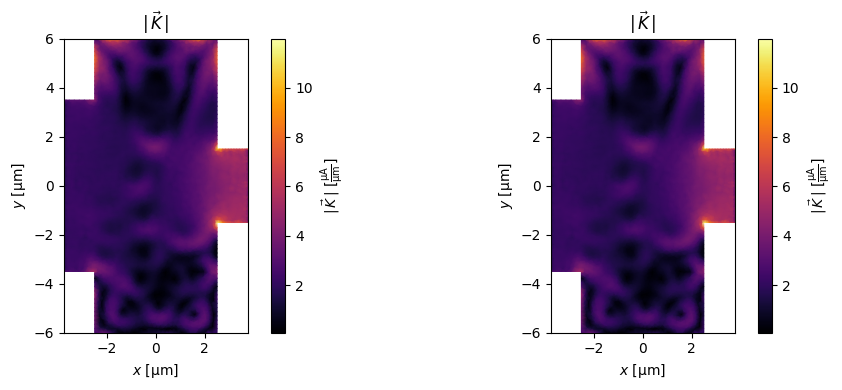

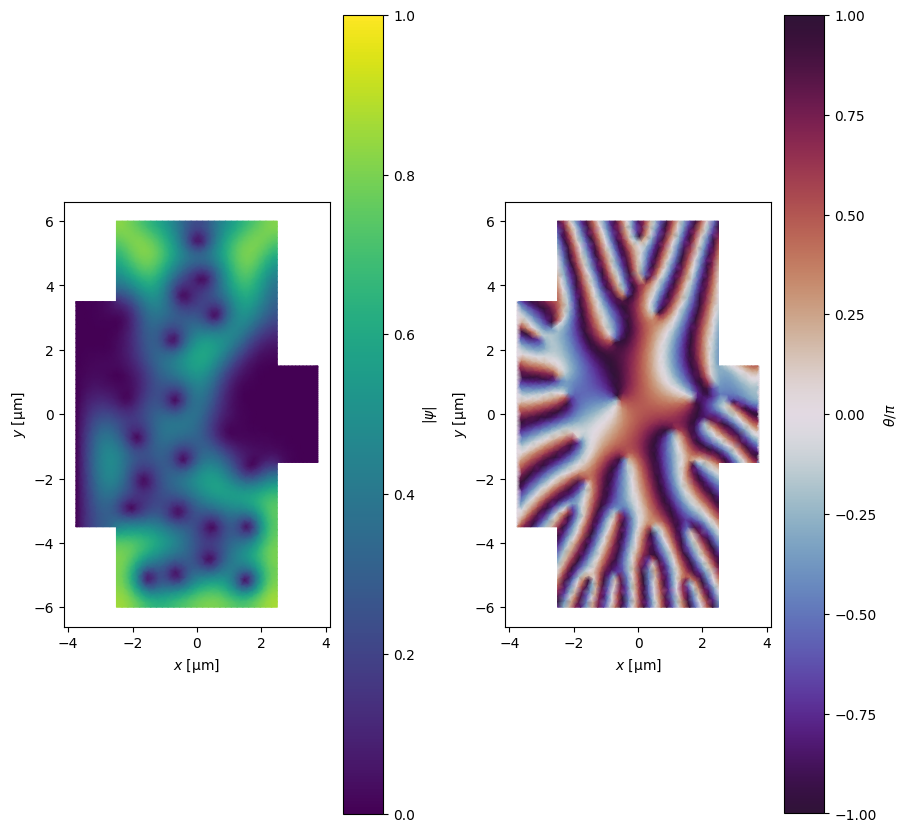

In [6]:
zero_field_solution = df.default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[15,-15],vector_potential = 1.0)
df.plot_solution(zero_field_solution)


Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\zero_field_zero_current-2.h5.
Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [02:03<00:00,  1.62tau/s ]


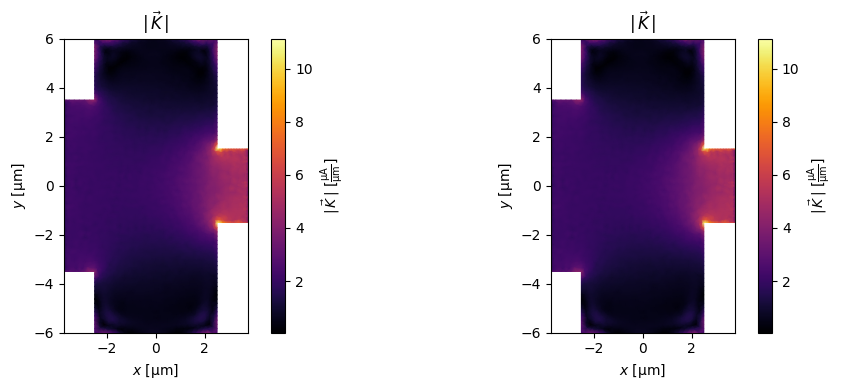

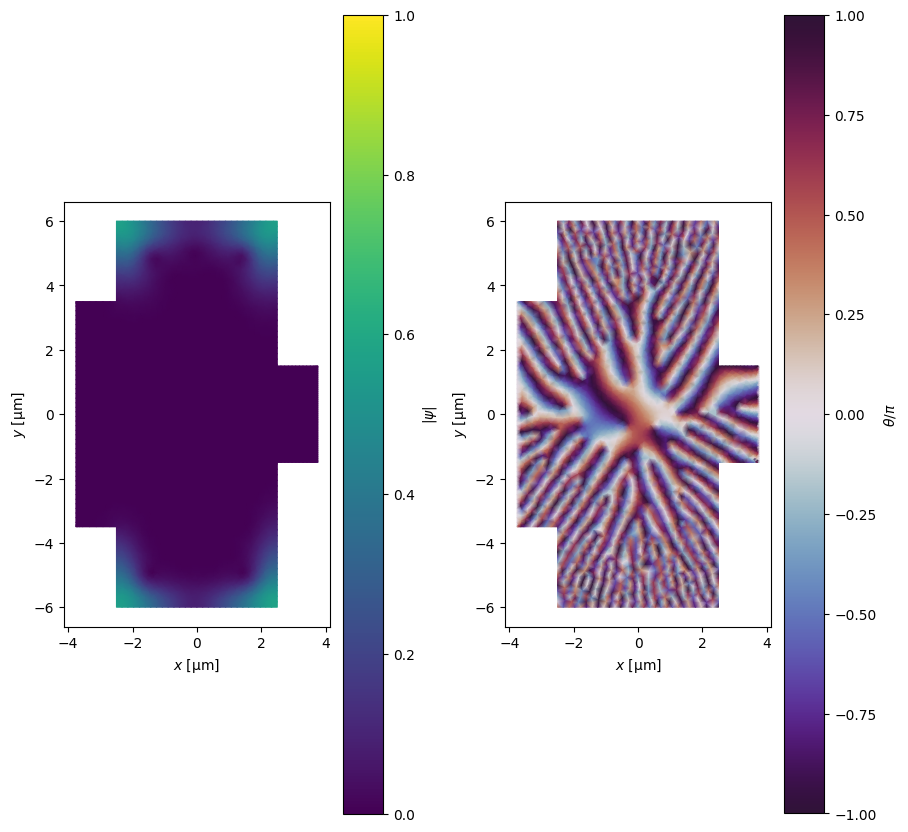

In [7]:
zero_field_solution = df.default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[15,-15],vector_potential = 2.0)
df.plot_solution(zero_field_solution)

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\zero_field_zero_current-3.h5.
Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [01:55<00:00,  1.73tau/s ]


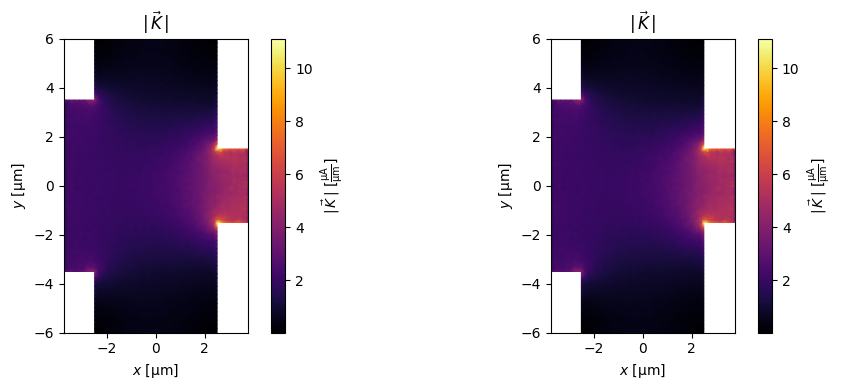

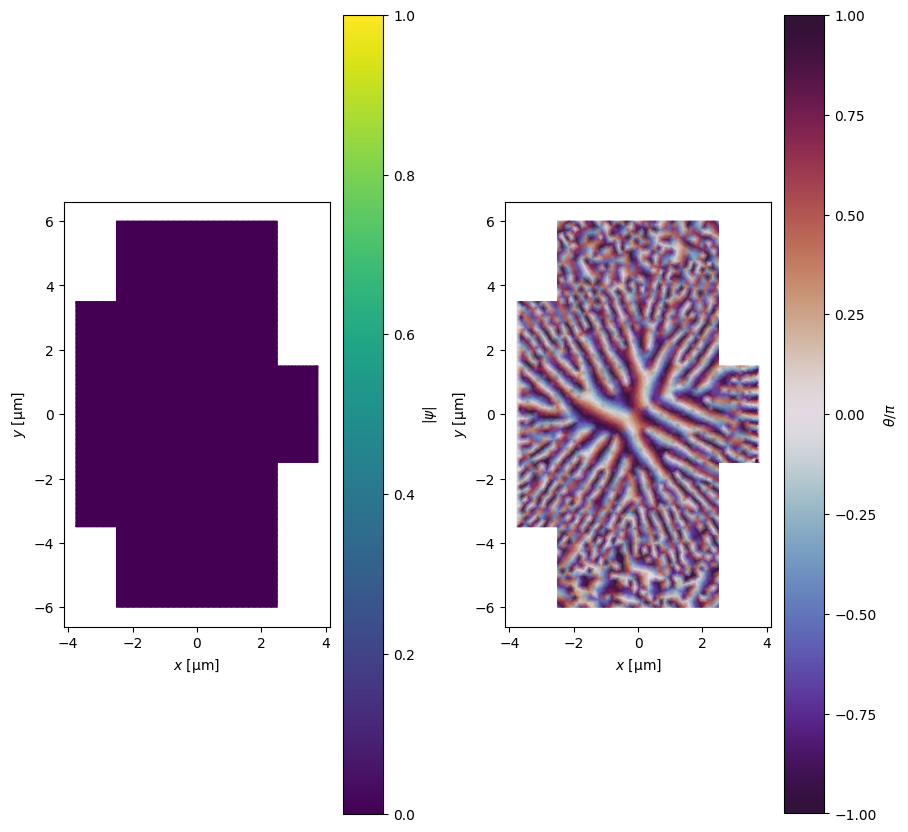

In [8]:
zero_field_solution = df.default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[15,-15],vector_potential = 3.0)
df.plot_solution(zero_field_solution)

## 2)Zero Currents

### 2.1)Constant Field for zero current

Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [01:53<00:00,  1.76tau/s ]


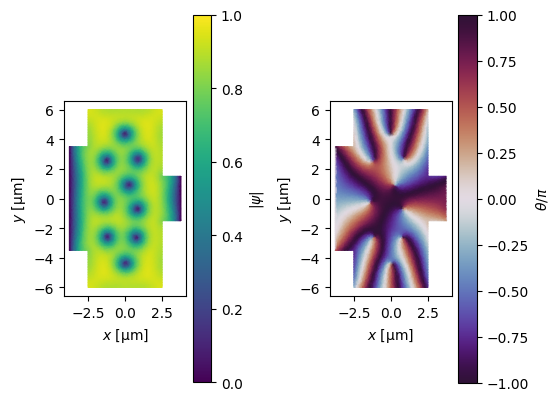

In [9]:
zero_current_solution =  df.default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=0.5)
fig, axes = zero_current_solution.plot_order_parameter(figsize=(10, 4))

### 2.2)varying fields for zero current

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\weak-link-zero-field-1.h5.
Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [02:07<00:00,  1.56tau/s ]


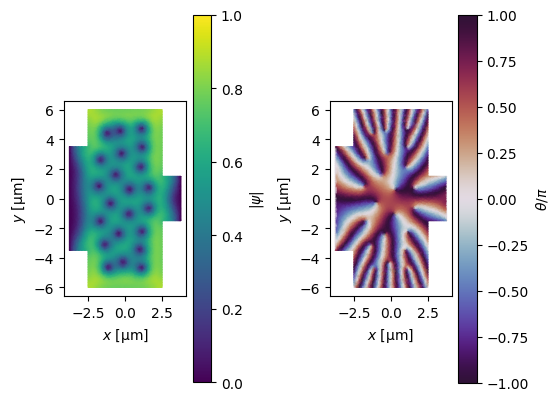

In [10]:
zero_current_solution_2 =  df.default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_2.plot_order_parameter(figsize=(10, 4))

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\weak-link-zero-field-2.h5.
Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [01:52<00:00,  1.77tau/s ]


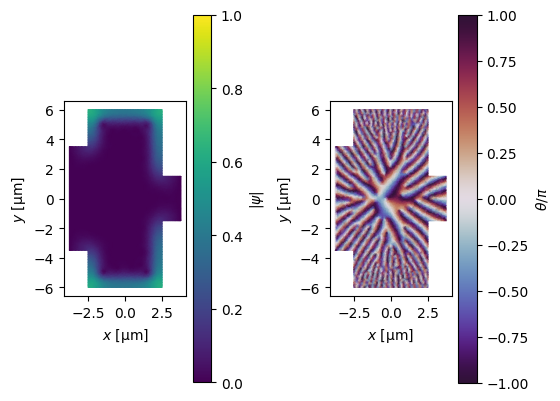

In [11]:
zero_current_solution_3 =  df.default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=2.0)
fig, axes = zero_current_solution_3.plot_order_parameter(figsize=(10, 4))

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\weak-link-zero-field-3.h5.
Simulating: 100%|██████████████████████████████████████████████████████████████████| 200/200 [01:51<00:00,  1.80tau/s ]


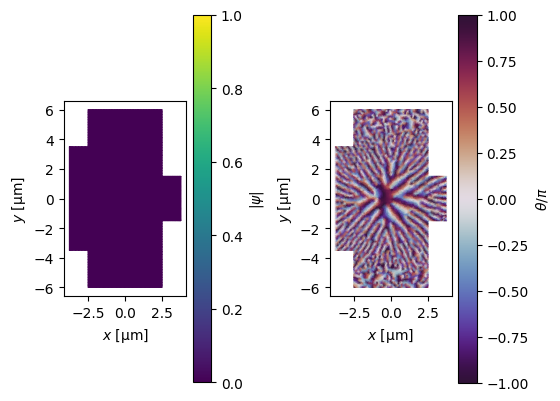

In [12]:
zero_current_solution_4 =  df.default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=3)
fig, axes = zero_current_solution_4.plot_order_parameter(figsize=(10, 4))

In [13]:
#if MAKE_ANIMATIONS:
#    zero_current_solution_video = df.make_video_from_solution(
#        zero_current_solution,
#        quantities=["order_parameter", "phase", "scalar_potential"],
#        figsize=(6.5, 4),
 
#    )
#    display(zero_current_solution_video)

### 2.3)Fixed field, zero current with different increments 

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\weak-link-zero-field-4.h5.


  Malla creada: 3132 puntos


Simulating: 100%|██████████████████████████████████████████████████████████████████| 200/200 [03:17<00:00,  1.01tau/s ]


Text(0.5, 1.0, 'variación en y 1')

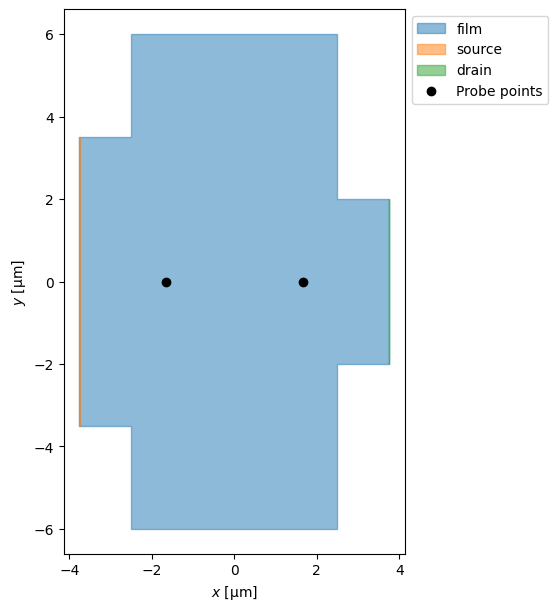

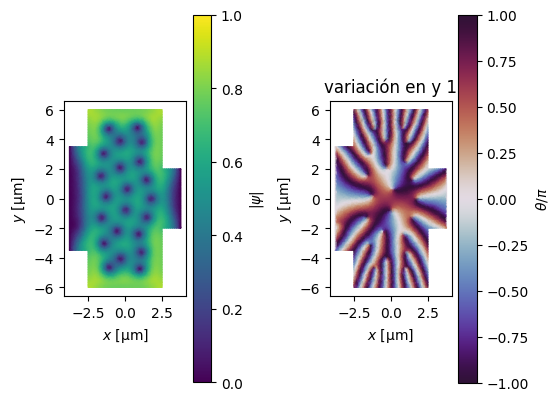

In [14]:
device_1 = df.create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=1)#h = 4
zero_current_solution_1 =  df.default_solution(device_1, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_1.plot_order_parameter(figsize=(10, 4))
plt.title(f'variación en y {1}')

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\weak-link-zero-field-5.h5.


  Malla creada: 3387 puntos


Simulating: 100%|██████████████████████████████████████████████████████████████████| 200/200 [02:17<00:00,  1.45tau/s ]


Text(0.5, 1.0, 'variación en y 2')

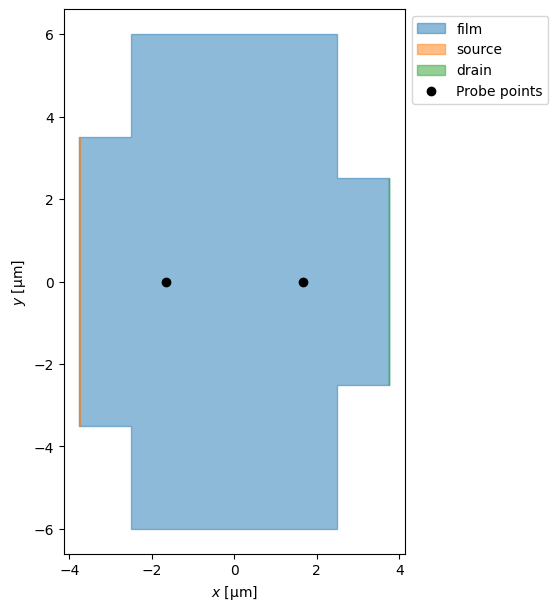

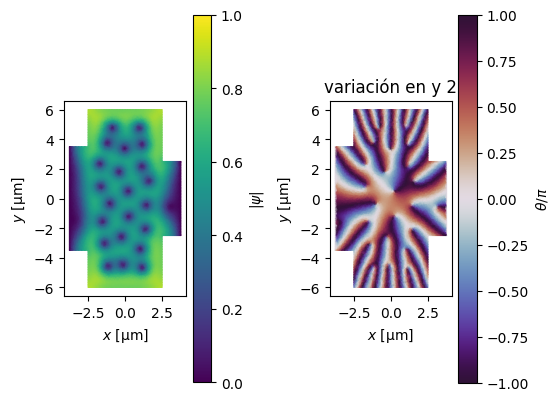

In [15]:
device_2 = df.create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=2)#h = 5
zero_current_solution_2 =  df.default_solution(device_2, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_2.plot_order_parameter(figsize=(10, 4))
plt.title(f'variación en y {2}')

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\weak-link-zero-field-6.h5.


  Malla creada: 3148 puntos


Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [01:12<00:00,  2.78tau/s ]


Text(0.5, 1.0, 'variación en y 3')

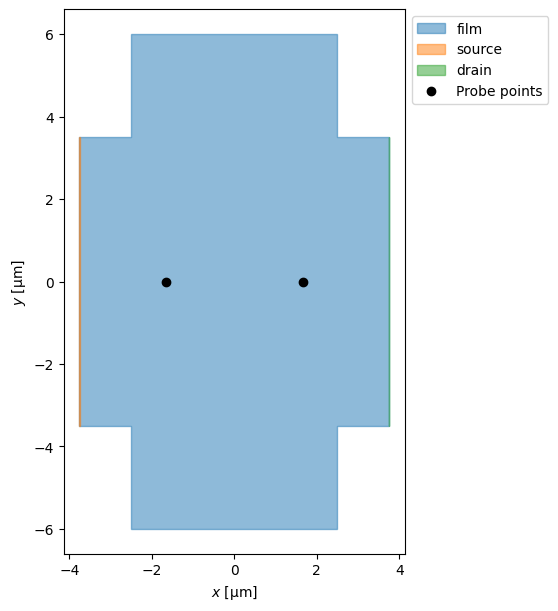

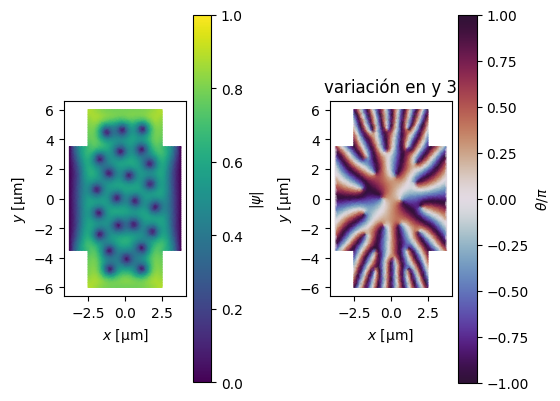

In [16]:
device_3 = df.create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=4)#h = y
zero_current_solution_3 =  df.default_solution(device_3, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_3.plot_order_parameter(figsize=(10, 4))
plt.title(f'variación en y {3}')

## 3)Magnetization

Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [01:22<00:00,  2.44tau/s ]
Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\Bscan-1.h5.
Simulating: 100%|██████████████████████████████████████████████████████████████████| 200/200 [01:06<00:00,  3.02tau/s ]
Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\Bscan-2.h5.
Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [00:48<00:00,  4.09tau/s ]
Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\Bscan-3.h5.
Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [01:30<00:00,  2.22tau/s ]
Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmp5wftgq4u\Bscan-4.h5.
Simulating: 100%|██████████████████████████████████████████████████████████████████| 200/200 [01:37<00:00,  2.05tau/s ]
Output f

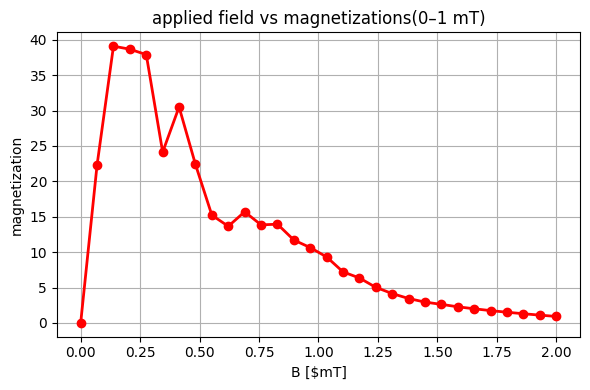

<Figure size 800x600 with 0 Axes>

In [17]:
# =========================
# 2) Applied field
# =========================
applied_field = np.linspace(0.0, 2, 30)  # External field on mT (B)
field_solutions,magnetization = df.solve_field(device_fast,applied_field)
plot_info = plot_labels={"fig_name":"currents.jpg","title":f'applied field vs magnetizations(0–1 mT)',"x":"B [$mT]","y":"magnetization"}
df.plot_parameters(applied_field, -magnetization,color_applied="red",plot_labels = plot_info)

## 4) varying currents

#### 4.1) Simulation with the default device

For now we make a superficial sweep with a # of steps that allows to see more or less where the critic currents are locted, then we sweep around those points with way more detail.
However i plan to observe the difference between points to see if a current treshold can be applied and automatically  sweep around the critic currents.

In [ ]:
co= 0
ci= 15 # current_interval
steps = 30
#currents = np.linspace(-ci, ci, steps)
currents = np.linspace(co, ci, steps)
# from -20 to 20 µA, step
voltages = df.current_application(device_fast, currents,B_field = 0)
plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({co}–{ci}µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
df.plot_parameters(currents,voltages,plot_info1)

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\D'
C:\Users\alejo\AppData\Local\Temp\ipykernel_15420\2689329755.py:8: SyntaxWarning: invalid escape sequence '\m'
  plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({co}–{ci}µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
C:\Users\alejo\AppData\Local\Temp\ipykernel_15420\2689329755.py:8: SyntaxWarning: invalid escape sequence '\D'
  plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({co}–{ci}µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [00:50<00:00,  3.94tau/s ]


I = 0.0 µA, <V> = 0.0000 V₀,progress: 3.33%

Simulating: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:51<00:00,  3.87tau/s ]


I = 0.5 µA, <V> = 0.0019 V₀,progress: 6.67%

Thermalizing:  51%|████████████████████████████████▌                               | 102/200 [00:29<00:20,  4.72tau/s ]

In [ ]:
df.critic_currents_augmentation(device_fast,[3,6,9,11,15],currents,voltages)

### 4.2)Different fields with varying currents

In [ ]:
for applied_field in range(1,4):
    voltages = df.current_application(device_fast, currents,B_field =applied_field)
    actual_voltages = voltages 
    plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({co}–{ci}
    µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
    df.plot_parameters(currents,actual_voltages,plot_info1)

In [ ]:
plt.title(f'Curva Voltaje vs Corriente ({co}–{ci} µA)')
plt.xlabel("Corriente $I$ [$\mu$A]")
plt.ylabel("Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]")
plt.scatter(currents,actual_voltages[0],'--g')
plt.scatter(currents,actual_voltages[1],'--r')
plt.scatter(currents,actual_voltages[2],'--b')
plt.plot()

### 4.3) Zero field with varying currents and device modifications

In [ ]:
print(f'widths: width_x:{width_x},width_x2:{width_x2},height_y:{height_y},height_y2:{height_y2},height_y2_altered:{3}' )


In [ ]:
#height2 = de 4 a 7
io = 1
ifi = 4
size = ifi - io +1
voltages_arr = []
devices_arr = []
J = 0



In [ ]:
voltages_arr = df.varying_increments(half_geometry,currents,io,ifi)

In [ ]:
for j in range(0,3):
    plot_info2 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente variación de x: {j} (0–15 µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
    df.plot_parameters(currents,voltages_arr[j],plot_info2)